In [1]:
from google.colab import files

# Upload file yalefaces.zip (bạn tải từ Kaggle hoặc nguồn tin cậy)
uploaded = files.upload()

In [2]:
from zipfile import ZipFile
import os
import tarfile

# Giải nén
with tarfile.open("yalefaces.tar.gz", 'r:gz') as tar_ref:
    tar_ref.extractall("yalefaces")

# Kiểm tra thư mục chứa ảnh
print("Files:", os.listdir("yalefaces"))

Files: ['Readme', 'yalefaces']


In [3]:
print(os.listdir("yalefaces/yalefaces"))

['subject14.glasses', 'subject11.wink', 'subject01.happy', 'subject08.sad', 'subject10.normal', 'subject02.leftlight', 'subject05.happy', 'subject04.wink', 'subject07.sleepy', 'subject15.sad', 'subject02.glasses', 'subject07.centerlight', 'subject05.sad', 'subject02.happy', 'subject09.wink', 'subject11.centerlight', 'subject09.noglasses', 'subject13.normal', 'subject12.surprised', 'subject14.wink', 'subject01.noglasses', 'subject08.normal', 'subject09.glasses', 'subject11.sleepy', 'subject06.sleepy', 'subject07.happy', 'subject06.centerlight', 'subject09.happy', 'subject08.noglasses', 'subject14.happy', 'subject12.centerlight', 'subject12.sad', 'subject05.centerlight', 'subject09.surprised', 'subject03.sleepy', 'subject14.surprised', 'subject13.glasses', 'subject01.sad', 'subject03.rightlight', 'subject04.glasses', 'subject15.glasses', 'subject04.centerlight', 'subject09.sleepy', 'subject08.happy', 'subject12.glasses', 'subject05.leftlight', 'subject07.glasses', 'subject07.wink', 'subj

In [4]:
import numpy as np
from PIL import Image
import os

def load_images(data_dir):
    X, y = [], []

    # Lấy tất cả file bắt đầu bằng 'subject'
    img_files = [f for f in os.listdir(data_dir) if f.startswith("subject")]
    #img_files = img_files[:10]  # chỉ dùng 50 ảnh đầu tiên

    if not img_files:
        print("⚠️ Warning: No image files found in the directory.")
        return np.array(X), np.array(y)

    for fname in img_files:
        try:
            img_path = os.path.join(data_dir, fname)
            img = Image.open(img_path).convert("L").resize((100, 100)) # convert ảnh về grayscale
            X.append(np.array(img).flatten())

            person_id = fname.split('.')[0]  # Lấy phần 'subject01'
            y.append(person_id)
        except Exception as e:
            print(f"❌ Error loading {fname}: {e}")

    return np.array(X), np.array(y)

# Gọi hàm với đường dẫn chính xác
X, y = load_images("yalefaces/yalefaces")
print("✅ Tổng số ảnh:", len(X))
if len(X) > 0:
    print("📐 Kích thước ảnh:", X[0].shape)

✅ Tổng số ảnh: 165
📐 Kích thước ảnh: (10000,)


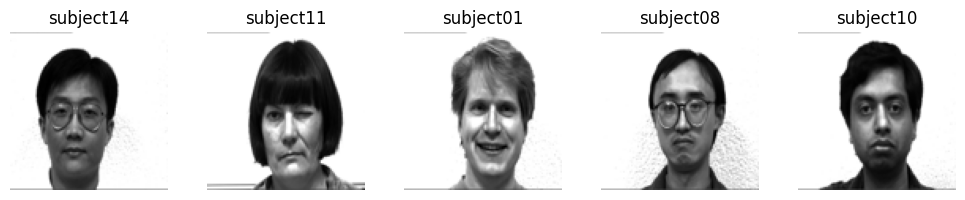

In [5]:
import matplotlib.pyplot as plt

def show_sample_images(X, y, image_shape, num=5):
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(X[i].reshape(image_shape), cmap='gray')
        plt.title(y[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# The image shape should be (100, 100) as the images were resized in load_images function
image_shape = (100, 100)  # Correct image shape
show_sample_images(X, y, image_shape)

In [6]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
def pca_manual(X, num_components):
    # Chuẩn hóa dữ liệu (zero mean)
    mean_face = np.mean(X, axis=0)
    X_centered = X - mean_face

    # Tính ma trận hiệp phương sai (covariance matrix)
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Tính eigenvalues và eigenvectors
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)

    # Sắp xếp theo eigenvalue giảm dần
    idx = np.argsort(eig_vals)[::-1]
    eig_vecs = eig_vecs[:, idx]
    eig_vals = eig_vals[idx]

    # Giữ lại số thành phần chính
    components = eig_vecs[:, :num_components]

    # Dựng lại dữ liệu theo không gian chính
    X_projected = np.dot(X_centered, components)

    return X_projected, components, mean_face

In [8]:
def show_eigenfaces(eigenfaces, image_shape, num=10):
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(2, 5, i+1)
        plt.imshow(eigenfaces[i].reshape(image_shape), cmap='gray')
        plt.title(f"PC {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

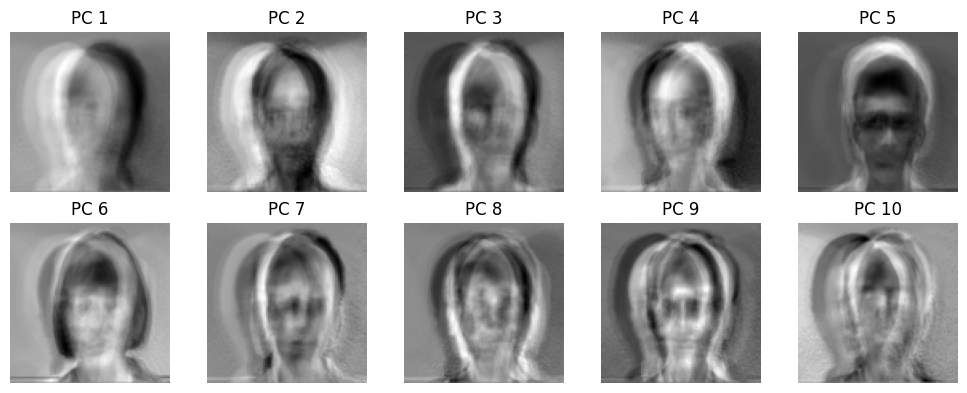

In [9]:
# Dùng PCA thủ công
X_train_proj, eigenfaces, mean_face = pca_manual(X_train, num_components=20)

# Vẽ 10 eigenfaces đầu
show_eigenfaces(eigenfaces.T, image_shape, num=10)


In [10]:
import numpy as np

def predict(X_test_proj, X_train_proj, y_train):
  """Predicts labels for test data using nearest neighbors in PCA space.

  Args:
    X_test_proj: Projected test data.
    X_train_proj: Projected training data.
    y_train: Training labels.

  Returns:
    Predicted labels for test data.
  """
  y_pred = []
  for test_point in X_test_proj:
    distances = np.sum((X_train_proj - test_point)**2, axis=1)  # Calculate Euclidean distances
    nearest_neighbor_idx = np.argmin(distances)  # Find index of nearest neighbor
    y_pred.append(y_train[nearest_neighbor_idx])  # Assign label of nearest neighbor
  return np.array(y_pred)

In [11]:
# Chiếu dữ liệu test lên không gian chính
X_test_centered = X_test - mean_face
X_test_proj = np.dot(X_test_centered, eigenfaces)

# Dự đoán
y_pred = predict(X_test_proj, X_train_proj, y_train)
accuracy = np.mean(y_pred == y_test)
print("🎯 Accuracy:", accuracy)

🎯 Accuracy: 0.7272727272727273


In [12]:
import gc
# del X_train_proj, cov_matrix, eig_vals, eig_vecs  # This line is causing the error because of cov_matrix, eig_vals, eig_vecs.
# The variables X_train_proj, eigenfaces, mean_face, X, y, X_train, X_test, y_train, y_test, X_test_proj, y_pred are defined in the previous cells.
# Re-run the cells in order if needed.
# Delete variables that are no longer needed.
del eigenfaces, mean_face, X, y, X_train, X_test, y_train, y_test, X_test_proj, y_pred
gc.collect() # Call the garbage collector.

20307